In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.utilities.rank_zero import rank_zero_only # NEW
from datetime import datetime

# Bacis libraries #
import os   
from dotenv import load_dotenv
load_dotenv('/home/pk21271/keys/key.env')
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

# ## Specify dataset files to run over ##
# path = "/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL{year}_ml_inputs/{dataset}.parquet"

# datasets = [
#     'ttH_HToInvisible_M125',
#     'TTToSemiLeptonic',
# ]
# years = ['2018']

# files = [
#     path.format(year=year, dataset=dataset)
#     for dataset in datasets
#     for year in years
# ]

# ## Data preprocessing ##
# df = load_from_parquet(files)
# df = remove_negative_events(df)
# df["target"] = create_target_labels(df["dataset"])
# apply_reweighting_per_class(df)
# reweighting = torch.Tensor(df['weight_training'].values)
# weight_nominal = torch.Tensor(df['weight_nominal'].values) # Add this to track nominal weights 
# df["target"] = create_target_labels(df["dataset"])

# X, y, pad_mask = awkward_to_inputs_parallel(df, n_processes=8, target_length=10)

# event_level = get_event_level(df)
#split_masks = kfold_split(df, k=2)      # returns a list with a mask for each fold, so if only training one select it in line below
#split = split_masks[0]

#### IMPORT DATA ALREADY PROCESSED

import torch

# Main path
main_path = '/home/pk21271/msciproject/prep_data/ttH_ttSL/'

# File paths
x_path = os.path.join(main_path, 'X.pt')
y_path = os.path.join(main_path, 'y.pt')
pad_mask_path = os.path.join(main_path, 'pad_mask.pt')
reweighting_path = os.path.join(main_path, 'reweighting.pt')
weight_nom_path = os.path.join(main_path, 'weight_nom.pt')
event_level_path = os.path.join(main_path, 'event_level.pt')

# Load data
X = torch.load(x_path)
y = torch.load(y_path)
pad_mask = torch.load(pad_mask_path)
reweighting = torch.load(reweighting_path)
weight_nom = torch.load(weight_nom_path)
event_level = torch.load(event_level_path)

## Create training datasets ## Also added the nominal weights
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_nom, val_nom = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level,
    weight_nom, 
    test_size=0.2,  
    random_state=42,
)

train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 2048

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = 11, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    num_workers = 11,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

/tmp/ipykernel_46840/201806434.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(x_path)
/tmp/ipykernel_46840/201806434.py:53: FutureWarning: You are using

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


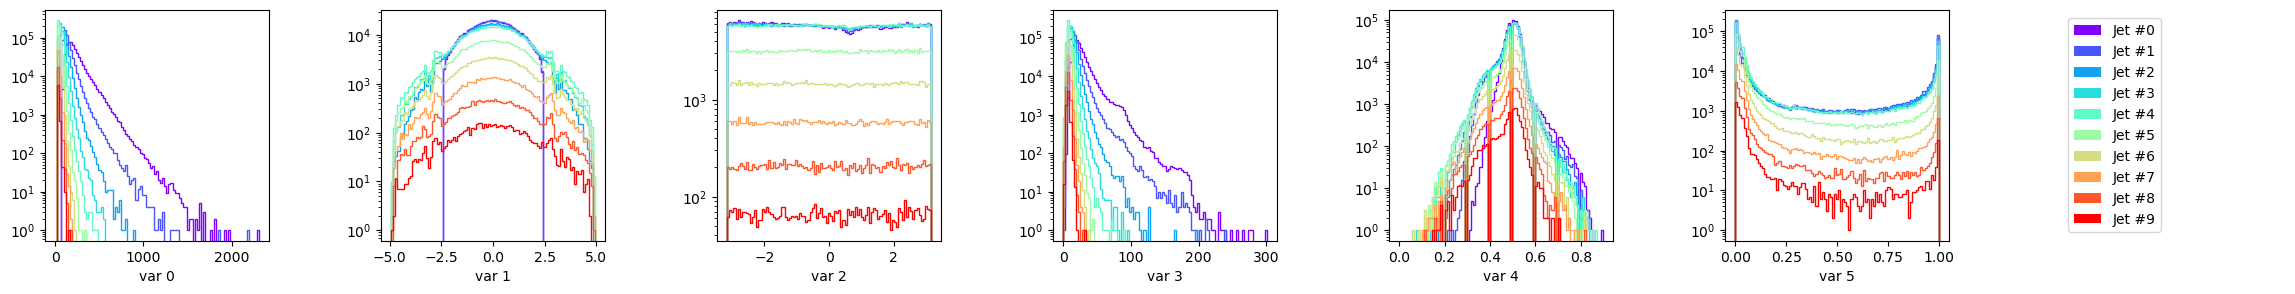

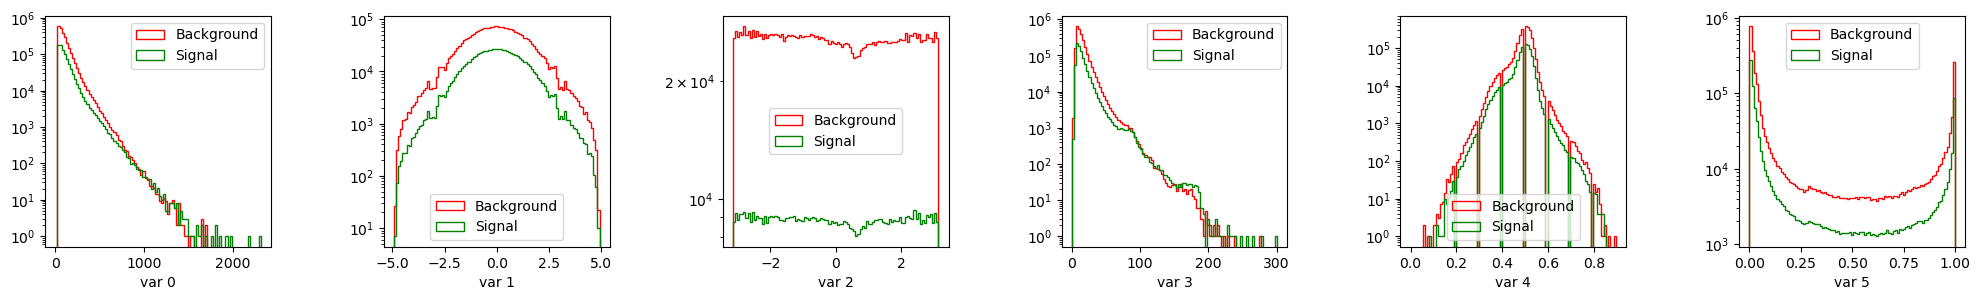

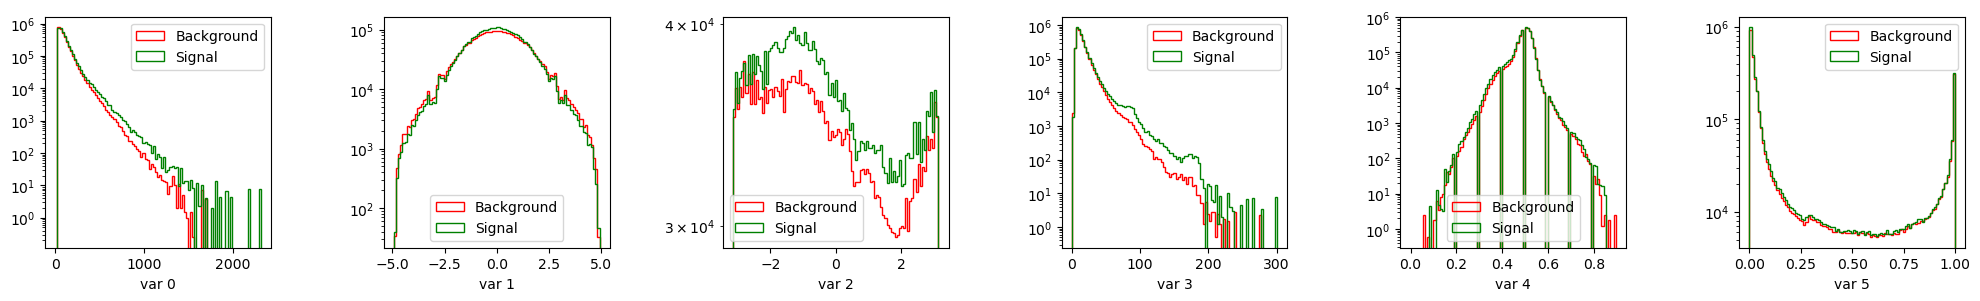

In [3]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [4]:
# Define model #
loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True) # Create new one for multiclass, MDMM mechanism
# loss = BCE + lambda * decorrelated loss # WHAT IS LAMBDA
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = 1,                  # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) norm is 4
    encoder_layers = 5,              # Number of encoder layers (self attention on jets)
    class_layers = 2,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = 3,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.2,                  # Dropout rate - default was 0.1
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [5]:
##### Parameters #####
epochs = 150
# lr = 1e-4
lr = 5e-4

print(len(train_dataset), len(valid_dataset))

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.25, 
   patience = 6, #Was 10
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=12,          # Number of epochs with no improvement after which training will be stopped #Defacult was 30, changed to 8
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"), 
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode


## Logger ## (THIS IS THE NEW ONE WITH THE PATH SETUP)
logger = CometLogger(
    api_key = os.getenv("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = "Setup",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    strategy = "ddp_notebook",
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [0,1,2,3],  # Use only one GPU
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train, # This is logging the wrong number
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

459631 114908
Training   : Batch size = 2048 => 225 steps per epoch
Validation : Batch size = 10000 => 12 steps per epoch


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (57) is smaller than the logging interval Trainer(log_every_n_steps=225). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved. New best score: 1.341
[rank: 2] Metric val/loss_tot improved. New best score: 1.341
[rank: 3] Metric val/loss_tot improved. New best score: 1.341
[rank: 1] Metric val/loss_tot improved. New best score: 1.341


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.034 >= min_delta = 0.0. New best score: 1.307
[rank: 2] Metric val/loss_tot improved by 0.034 >= min_delta = 0.0. New best score: 1.307
[rank: 1] Metric val/loss_tot improved by 0.034 >= min_delta = 0.0. New best score: 1.307
[rank: 3] Metric val/loss_tot improved by 0.034 >= min_delta = 0.0. New best score: 1.307


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.281
[rank: 2] Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.281
[rank: 3] Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.281
[rank: 1] Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.281


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.037 >= min_delta = 0.0. New best score: 1.243
[rank: 2] Metric val/loss_tot improved by 0.037 >= min_delta = 0.0. New best score: 1.243
[rank: 3] Metric val/loss_tot improved by 0.037 >= min_delta = 0.0. New best score: 1.243
[rank: 1] Metric val/loss_tot improved by 0.037 >= min_delta = 0.0. New best score: 1.243


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.230
[rank: 2] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.230
[rank: 3] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.230
[rank: 1] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.230


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.025 >= min_delta = 0.0. New best score: 1.205
[rank: 2] Metric val/loss_tot improved by 0.025 >= min_delta = 0.0. New best score: 1.205
[rank: 3] Metric val/loss_tot improved by 0.025 >= min_delta = 0.0. New best score: 1.205
[rank: 1] Metric val/loss_tot improved by 0.025 >= min_delta = 0.0. New best score: 1.205


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.195
[rank: 2] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.195
[rank: 1] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.195
[rank: 3] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.195


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.188
[rank: 2] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.188
[rank: 3] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.188
[rank: 1] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.188


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.182
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.182
[rank: 3] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.182
[rank: 1] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.182


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.038 >= min_delta = 0.0. New best score: 1.144
[rank: 3] Metric val/loss_tot improved by 0.038 >= min_delta = 0.0. New best score: 1.144
[rank: 1] Metric val/loss_tot improved by 0.038 >= min_delta = 0.0. New best score: 1.144
[rank: 2] Metric val/loss_tot improved by 0.038 >= min_delta = 0.0. New best score: 1.144


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.125
[rank: 1] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.125
[rank: 2] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.125
[rank: 3] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.119
[rank: 2] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.119
[rank: 3] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.119
[rank: 1] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.119


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.118
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.118
[rank: 3] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.118
[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.118


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.102
[rank: 1] Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.102
[rank: 2] Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.102
[rank: 3] Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.102


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.101
[rank: 2] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.101
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.101
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.101


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.100
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.100
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.100
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099
[rank: 2] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.098
[rank: 3] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.098
[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.098
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.098


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Monitored metric val/loss_tot did not improve in the last 12 records. Best score: 1.098. Signaling Trainer to stop.
[rank: 3] Monitored metric val/loss_tot did not improve in the last 12 records. Best score: 1.098. Signaling Trainer to stop.
[rank: 1] Monitored metric val/loss_tot did not improve in the last 12 records. Best score: 1.098. Signaling Trainer to stop.
[rank: 2] Monitored metric val/loss_tot did not improve in the last 12 records. Best score: 1.098. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : https://www.comet.com/inigostibbe/analysisobjecttransformer/78b7658c6a7e4414b7157f30dcbfb3a7
COMET INFO:   M

In [6]:
## Testing model performance on validation set ##
single_gpu_trainer = L.Trainer(accelerator="gpu", devices=1)
preds = single_gpu_trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

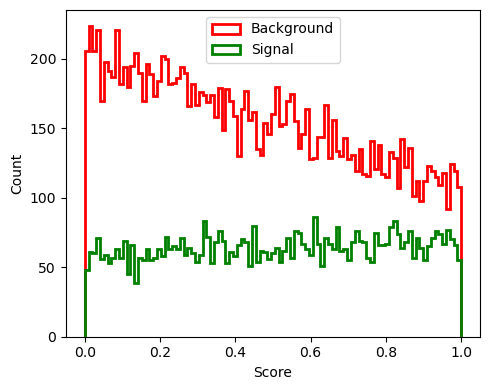

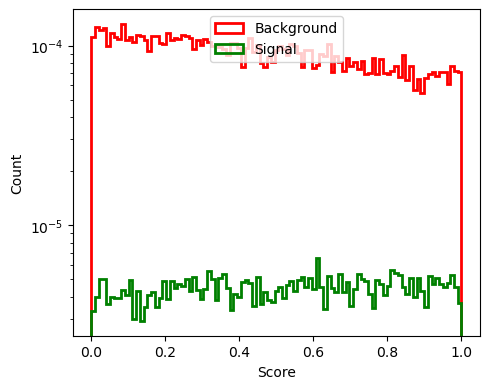

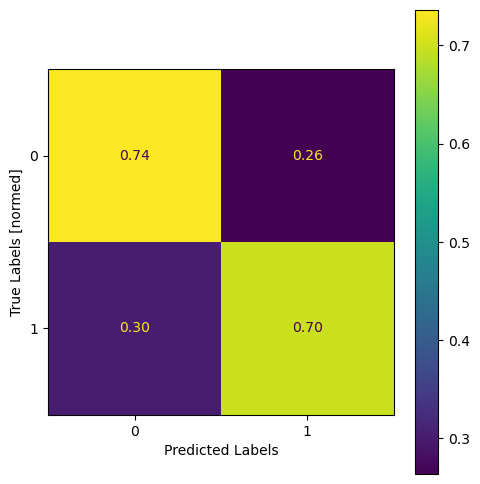

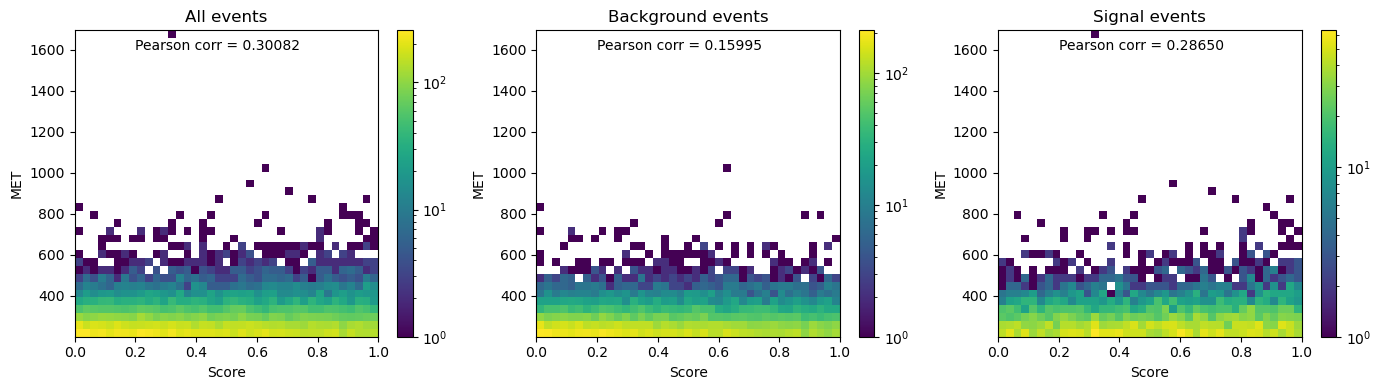

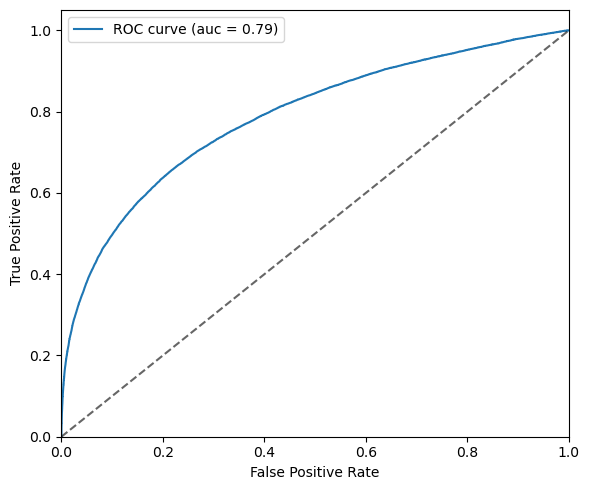

In [7]:
fig = plot_score(labels,preds,outdir=outdir,bins=100,log=False)
fig = plot_score(labels,preds,weights=val_nom,outdir=outdir,bins=100,log=True)
fig = plot_confusion_matrix(labels, torch.sigmoid(preds), outdir=outdir,show=True)
fig = plot_correlation(labels,preds,event,outdir=outdir,log=True,bins=40)
fig = plot_roc(labels, preds, outdir=outdir,show=True)

## Plot significance + weighted ROC

(114908,) (114908,) (114908,)


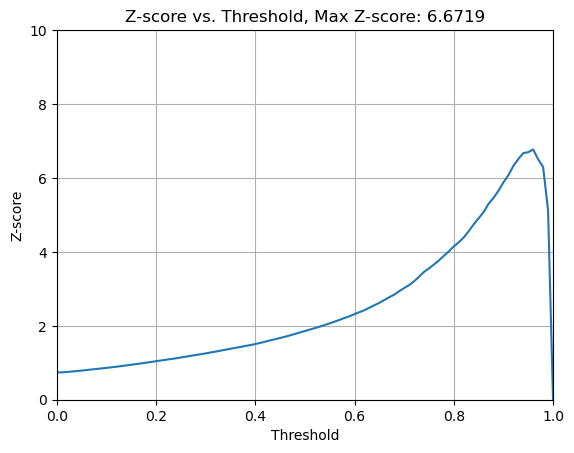

In [8]:
# Weights array
wn = np.array((val_nom * 200000).flatten()) #weight nominal
probs = np.array(torch.sigmoid(preds).flatten())
labels = np.array(labels.flatten())
thresholds = np.linspace(0, 1, 101)
z_scores = []

print(wn.shape, probs.shape, labels.shape)

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn[(probs > threshold) & (labels == 1)])  # Weighted Signal
    B = np.sum(wn[(probs > threshold) & (labels == 0)])  # Weighted Background
    sig_B = B * 0.05 # 5% error
    
    Z = S / np.sqrt(B + sig_B**2 + 1e-10)

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score vs. Threshold, Max Z-score: {max(z_scores[:95]):.4f}")
plt.grid()
plt.ylim(0,10)
plt.xlim(0,1)
plt.show()

In [9]:
def plot_weighted_roc_curve(y_true, y_pred_proba, sample_weights=None, title="Weighted ROC Curve"):
    """
    Plot a ROC curve with optional sample weights.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred_proba : array-like
        Predicted probabilities for the positive class
    sample_weights : array-like, optional
        Sample weights for each observation
    title : str, optional
        Title for the plot
    
    Returns:
    --------
    tuple
        (fpr, tpr, thresholds, weighted_auc)
    """
    # If no weights provided, use uniform weights
    if sample_weights is None:
        sample_weights = np.ones(len(y_true))
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba, sample_weight=sample_weights)
    
    # Calculate weighted AUC
    # We'll use the trapezoidal rule to compute the area
    weighted_auc = np.trapz(tpr, fpr)
    
    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, 'b-', label=f'Weighted ROC (AUC = {weighted_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Set the plot limits
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])

    
    return fpr, tpr, thresholds, weighted_auc

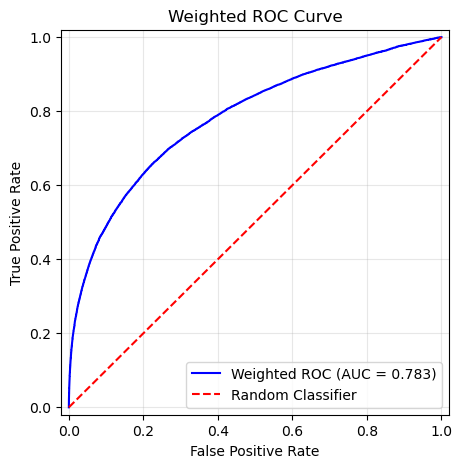

In [10]:
plot_weighted_roc_curve(labels, probs, wn, title="Weighted ROC Curve")
plt.show()



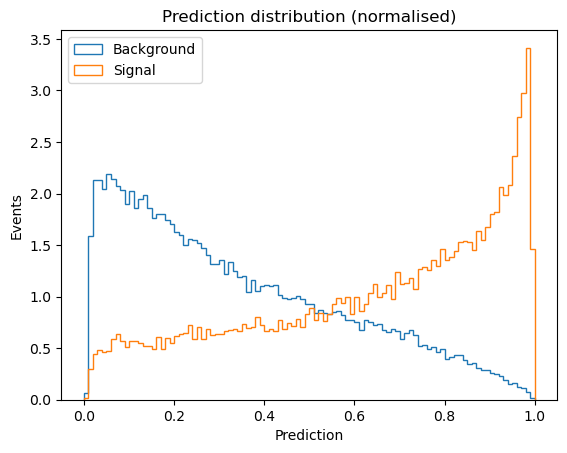

In [11]:
# Plot histogram of the predictions

plt.hist(probs[labels == 0], bins=100, range=(0, 1), weights=wn[labels == 0], histtype='step', label='Background', density = True)
plt.hist(probs[labels == 1], bins=100, range=(0, 1), weights=wn[labels == 1], histtype='step', label='Signal', density = True)
plt.legend()  
plt.xlabel('Prediction')
plt.ylabel('Events')
plt.title('Prediction distribution (normalised)')   
plt.show()